In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import optax
import scipy.linalg
import scipy.signal
import torch
import matplotlib.pyplot as plt
from flax import linen as nn
from torch.utils.data import Dataset, DataLoader

def np_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [np_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

In [2]:
# Setup seed 
torch.random.manual_seed(0)
np.random.seed(0)
key = jax.random.PRNGKey(0)

In [3]:
A = np.array([[0,1],[0,0]])
B = np.array([[0],[1]])
Q = np.array([[1,0],[0,1]])
R = np.array([[0.01]])
R_inv = scipy.linalg.inv(R)

P = scipy.linalg.solve_continuous_are(A,B,Q,R)

Build dynamics simulation

In [4]:
dt = 0.01
state_dim = A.shape[0]
u_dim = B.shape[1]
A_d, B_d, _, _, _ = scipy.signal.cont2discrete((A, B, np.eye(state_dim), np.eye(u_dim)), dt=dt)

def dynamics_step(x, u):
    return A_d @ x + B_d @ u


In [5]:
class PSDValueApproximator(nn.Module):
    @nn.compact
    def __call__(self, x):
        y = nn.Dense(128, use_bias=False)(x)
        y = jnp.sin(y)
        y = nn.Dense(128, use_bias=False)(y)
        y = jnp.sin(y)
        y = nn.Dense(64, use_bias=False)(y)
        y = jnp.einsum('...i,...i->...', y, y) + 1e-3 * jnp.einsum('...i,...i->...', x, x)

        return y.squeeze()
    
class SoftPSDValueApproximator(nn.Module):
    @nn.compact
    def __call__(self, x):
        y = nn.Dense(128)(x)
        y = jnp.sin(y)
        y = nn.Dense(128)(y)
        y = jnp.sin(y)
        y = nn.Dense(64)(y)
        y = jnp.sin(y)
        y = nn.Dense(1)(y)

        return y.squeeze()

Generate datasets

In [6]:
metric = 1e-4
xs = np.random.uniform(low=-1,high=1, size=(2**16, 2))
norms = np.array([x.T @ x for x in xs])
running_costs = np.where(norms > metric, 1, 0)

class StateDataset(Dataset):
    def __init__(self, xs, running_costs):
        super().__init__()
        self.xs = xs
        self.running_costs = running_costs
    def __len__(self):
        return self.xs.shape[0]
    def __getitem__(self, index):
        return self.xs[index], self.running_costs[index]
    
dataset = StateDataset(xs, running_costs)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, collate_fn=np_collate, drop_last=False)

Code for evaluate average cumulated costs

In [7]:
def get_mean_and_std_of_policy(model, model_params, model_states, num_of_trajectory = 20, max_T=15):
    
    @jax.jit
    def get_control(x):
        v_gradient, _ = jax.grad(model.apply, argnums=1, has_aux=True)({'params': model_params, **model_states}, x, mutable=list(model_states.keys()))
        u = -jnp.sign(v_gradient @ B) 
        return u
    
    ts = np.arange(0, max_T, dt)
    optimal_cutting_time_list = []

    for i in range(num_of_trajectory):
        x = np.random.uniform(low=-1,high=1, size=(2,))
        for t in ts:
            if x.T @ x <= metric:
                optimal_cutting_time_list.append(t)
                break
            u = np.array(get_control(x))
            x = dynamics_step(x, u)
        if t >= max_T - dt:
            optimal_cutting_time_list.append(max_T)
    
    optimal_cutting_time_list = np.array(optimal_cutting_time_list)

    return np.mean(optimal_cutting_time_list), np.std(optimal_cutting_time_list)

Code for training PSD value function

In [8]:
psd_value_function_approximator = PSDValueApproximator()
key, key_to_use = jax.random.split(key)
psd_model_variables = psd_value_function_approximator.init(key_to_use, jnp.zeros((1,2)))
psd_model_states, psd_model_params = psd_model_variables.pop('params')
del psd_model_variables
psd_optimizer = optax.adam(learning_rate=1e-3)
psd_optimizer_states = psd_optimizer.init(psd_model_params)

psd_cumulated_cost_during_learning_mean = []
psd_cumulated_cost_during_learning_std = []

def psd_hjb_loss(params, states, xs, running_costs):
    def get_v_gradient(params, states, x):
        return jax.grad(psd_value_function_approximator.apply, argnums=1, has_aux=True)({'params': params, **states}, x, mutable=list(states.keys()))
    def loss(x, running_cost):
        v_gradient, updated_states = get_v_gradient(params, states, x)
        u = -jnp.sign(v_gradient @ B) 
        x_dot = A @ x + B @ u
        v_dot = v_gradient.T @ x_dot
        loss = jnp.abs(v_dot + running_cost)
        return loss, updated_states    
    batch_losses, updated_states = jax.vmap(loss)(xs, running_costs)
    return jnp.mean(batch_losses), updated_states

@jax.jit
def psd_params_update(params, states, optimizer_state, xs, running_costs):
    (loss, updated_states), hjb_grad = jax.value_and_grad(psd_hjb_loss, has_aux=True)(params, states, xs, running_costs)
    updates, optimizer_state = psd_optimizer.update(hjb_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, updated_states, optimizer_state, loss

psd_losses = []
for epoch in range(100):
    psd_total_loss = 0

    psd_cumulated_cost_mean, psd_cumulated_cost_std = get_mean_and_std_of_policy(psd_value_function_approximator, psd_model_params, psd_model_states)
    psd_cumulated_cost_during_learning_mean.append(psd_cumulated_cost_mean)
    psd_cumulated_cost_during_learning_std.append(psd_cumulated_cost_std)

    for i, (xs, running_costs) in enumerate(dataloader):
        psd_model_params, psd_model_states, psd_optimizer_states, psd_loss = psd_params_update(psd_model_params, psd_model_states, psd_optimizer_states, xs, running_costs)
        psd_total_loss += psd_loss
    psd_losses.append(psd_total_loss / len(dataloader))
    if (epoch+1) % 10 == 0:
        print(f"epoch:{epoch+1} loss:{psd_total_loss / len(dataloader)}")

psd_cumulated_cost_during_learning_mean = np.array(psd_cumulated_cost_during_learning_mean)
psd_cumulated_cost_during_learning_std = np.array(psd_cumulated_cost_during_learning_std)


epoch:10 loss:0.07184618711471558
epoch:20 loss:0.05127125605940819
epoch:30 loss:0.050909679383039474
epoch:40 loss:0.044496916234493256
epoch:50 loss:0.035330913960933685
epoch:60 loss:0.04974454268813133
epoch:70 loss:0.02857941947877407
epoch:80 loss:0.025896722450852394
epoch:90 loss:0.025598838925361633
epoch:100 loss:0.026374680921435356


Code for training value function with soft PSD method

In [9]:
regularization = 1e0
soft_psd_value_function_approximator = SoftPSDValueApproximator()
key, key_to_use = jax.random.split(key)
soft_psd_model_variables = soft_psd_value_function_approximator.init(key_to_use, jnp.zeros((1,2)))
soft_psd_model_states, soft_psd_model_params = soft_psd_model_variables.pop('params')
del soft_psd_model_variables
soft_psd_optimizer = optax.adam(learning_rate=1e-3)
soft_psd_optimizer_states = soft_psd_optimizer.init(soft_psd_model_params)

soft_psd_cumulated_cost_during_learning_mean = []
soft_psd_cumulated_cost_during_learning_std = []

def soft_psd_hjb_loss(params, states, xs, running_costs):
    def get_v_gradient(params, states, x):
        return jax.value_and_grad(soft_psd_value_function_approximator.apply, argnums=1, has_aux=True)({'params': params, **states}, x, mutable=list(states.keys()))
    def get_v_at_zeros(params, states, x):
        return soft_psd_value_function_approximator.apply({'params': params, **states}, jnp.zeros_like(x))
    def loss(x, running_cost):
        (value, updated_states), v_gradient = get_v_gradient(params, states, x)
        value_at_zeros = get_v_at_zeros(params, states, x)
        u = -jnp.sign(v_gradient @ B) 
        x_dot = A @ x + B @ u
        v_dot = v_gradient.T @ x_dot
        loss = jnp.abs(v_dot + running_cost) + regularization * jnp.maximum(0, value_at_zeros-value)
        return loss, updated_states
    batch_losses, updated_states = jax.vmap(loss)(xs, running_costs)
    return jnp.mean(batch_losses), updated_states

def soft_psd_warmup_hjb_loss(params, states, xs, running_costs):
    def get_v_gradient(params, states, x):
        return jax.value_and_grad(soft_psd_value_function_approximator.apply, argnums=1, has_aux=True)({'params': params, **states}, x, mutable=list(states.keys()))
    def get_v_at_zeros(params, states, x):
        return soft_psd_value_function_approximator.apply({'params': params, **states}, jnp.zeros_like(x))
    def loss(x, running_cost):
        (value, updated_states), v_gradient = get_v_gradient(params, states, x)
        value_at_zeros = get_v_at_zeros(params, states, x)
        u = jnp.clip(-R_inv @ B.T @ P @ x, -1, 1)
        x_dot = A @ x + B @ u
        v_dot = v_gradient.T @ x_dot
        loss = jnp.abs(v_dot + running_cost) + regularization * jnp.maximum(0, value_at_zeros-value)
        return loss, updated_states
    batch_losses, updated_states = jax.vmap(loss)(xs, running_costs)
    return jnp.mean(batch_losses), updated_states

@jax.jit
def soft_psd_params_update(params, states, optimizer_state, xs, running_costs):
    (loss, updated_states), hjb_grad = jax.value_and_grad(soft_psd_hjb_loss, has_aux=True)(params, states, xs, running_costs)
    updates, optimizer_state = soft_psd_optimizer.update(hjb_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, updated_states, optimizer_state, loss

@jax.jit
def soft_psd_params_warmup_update(params, states, optimizer_state, xs, running_costs):
    (loss, updated_states), hjb_grad = jax.value_and_grad(soft_psd_warmup_hjb_loss, has_aux=True)(params, states, xs, running_costs)
    updates, optimizer_state = soft_psd_optimizer.update(hjb_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, updated_states, optimizer_state, loss

soft_psd_losses = []
warmup_epochs = 20
epochs = 100
for warmup_epoch in range(warmup_epochs):
    soft_psd_total_loss = 0

    soft_psd_cumulated_cost_mean, soft_psd_cumulated_cost_std = get_mean_and_std_of_policy(soft_psd_value_function_approximator, soft_psd_model_params, soft_psd_model_states)
    soft_psd_cumulated_cost_during_learning_mean.append(soft_psd_cumulated_cost_mean)
    soft_psd_cumulated_cost_during_learning_std.append(soft_psd_cumulated_cost_std)

    for i, (xs, running_costs) in enumerate(dataloader):
        soft_psd_model_params, soft_psd_model_states, soft_psd_optimizer_states, soft_psd_loss = soft_psd_params_warmup_update(soft_psd_model_params, soft_psd_model_states, soft_psd_optimizer_states, xs, running_costs)
        soft_psd_total_loss += soft_psd_loss
    soft_psd_losses.append(soft_psd_total_loss / len(dataloader))
    if (warmup_epoch+1) % 10 == 0:
        print(f"epoch:{warmup_epoch+1} loss:{soft_psd_total_loss / len(dataloader)}")

for epoch in range(warmup_epochs, epochs, 1):
    soft_psd_total_loss = 0

    soft_psd_cumulated_cost_mean, soft_psd_cumulated_cost_std = get_mean_and_std_of_policy(soft_psd_value_function_approximator, soft_psd_model_params, soft_psd_model_states)
    soft_psd_cumulated_cost_during_learning_mean.append(soft_psd_cumulated_cost_mean)
    soft_psd_cumulated_cost_during_learning_std.append(soft_psd_cumulated_cost_std)

    for i, (xs, running_costs) in enumerate(dataloader):
        soft_psd_model_params, soft_psd_model_states, soft_psd_optimizer_states, soft_psd_loss = soft_psd_params_update(soft_psd_model_params, soft_psd_model_states, soft_psd_optimizer_states, xs, running_costs)
        soft_psd_total_loss += soft_psd_loss
    soft_psd_losses.append(soft_psd_total_loss / len(dataloader))
    if (epoch+1) % 10 == 0:
        print(f"epoch:{epoch+1} loss:{soft_psd_total_loss / len(dataloader)}")

soft_psd_cumulated_cost_during_learning_mean = np.array(soft_psd_cumulated_cost_during_learning_mean)
soft_psd_cumulated_cost_during_learning_std = np.array(soft_psd_cumulated_cost_during_learning_std)


epoch:10 loss:0.035820987075567245
epoch:20 loss:0.028686590492725372
epoch:30 loss:0.02596471644937992
epoch:40 loss:0.0215497687458992
epoch:50 loss:0.01901579275727272
epoch:60 loss:0.017010189592838287
epoch:70 loss:0.016564253717660904
epoch:80 loss:0.015939142554998398
epoch:90 loss:0.01528205443173647
epoch:100 loss:0.013889515772461891


Make plots

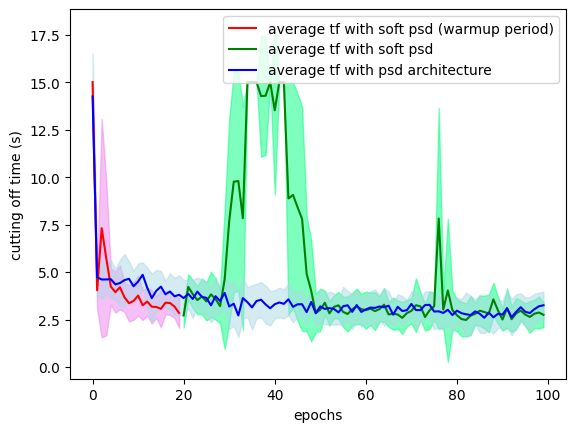

In [10]:
plt.figure()

plt.plot(soft_psd_cumulated_cost_during_learning_mean[:warmup_epochs], color="red", label="average tf with soft psd (warmup period)")
plt.fill_between(range(warmup_epochs),
                soft_psd_cumulated_cost_during_learning_mean[:warmup_epochs]+soft_psd_cumulated_cost_during_learning_std[:warmup_epochs], 
                soft_psd_cumulated_cost_during_learning_mean[:warmup_epochs] - soft_psd_cumulated_cost_during_learning_std[:warmup_epochs],
                color="violet", alpha=0.5)

plt.plot(range(warmup_epochs, epochs), soft_psd_cumulated_cost_during_learning_mean[warmup_epochs:], color="green", label="average tf with soft psd")
plt.fill_between(range(warmup_epochs, epochs),
                soft_psd_cumulated_cost_during_learning_mean[warmup_epochs:]+soft_psd_cumulated_cost_during_learning_std[warmup_epochs:], 
                soft_psd_cumulated_cost_during_learning_mean[warmup_epochs:] - soft_psd_cumulated_cost_during_learning_std[warmup_epochs:],
                color="springgreen", alpha=0.5)

plt.plot(psd_cumulated_cost_during_learning_mean, color="blue", label="average tf with psd architecture")
plt.fill_between(range(len(psd_cumulated_cost_during_learning_mean)), 
                 psd_cumulated_cost_during_learning_mean+psd_cumulated_cost_during_learning_std, 
                 psd_cumulated_cost_during_learning_mean-psd_cumulated_cost_during_learning_std, color="lightblue", alpha=0.5)

plt.legend()
plt.xlabel("epochs")
plt.ylabel("cutting off time (s)")
plt.show()

Load results from level set methods: Mitchell, Ian M., and Jeremy A. Templeton. "A toolbox of Hamilton-Jacobi solvers for analysis of nondeterministic continuous and hybrid systems." International workshop on hybrid systems: computation and control. Berlin, Heidelberg: Springer Berlin Heidelberg, 2005.

In [11]:
import os
import scipy.io
from scipy.interpolate import RegularGridInterpolator

results_by_level_set_method = scipy.io.loadmat(os.path.normpath(
    os.path.join(
        os.path.dirname(os.path.abspath("")),
        "examples/data/time_optimal_control_for_double_integrator_results_from_level_set_methods.mat",
        )
    ))

value_function_by_level_set_method = results_by_level_set_method["mttr"].T
value_function_by_analytical = results_by_level_set_method["attr"].T

grid_info = results_by_level_set_method["gridOut"]

pos_span = np.linspace(grid_info["min"][0][0][0][0], grid_info["max"][0][0][0][0], grid_info["N"][0][0][0][0])
vel_span = np.linspace(grid_info["min"][0][0][1][0], grid_info["max"][0][0][1][0], grid_info["N"][0][0][1][0])

dv = grid_info["dx"][0][0][1][0]

diffVdiffvel_by_level_set = (value_function_by_level_set_method[2:, :] - value_function_by_level_set_method[:-2, :]) / (2 * dv)

get_pVpvel= RegularGridInterpolator((vel_span[1:-1], pos_span), diffVdiffvel_by_level_set, method="nearest", bounds_error=False ,fill_value=None) 

def get_level_set_control(x):
    pVpvel = get_pVpvel(np.flip(x))
    return -np.array(np.sign(pVpvel))

def get_analytical_control(x):
    if (x[1] < 0 and x[0] <= 0.5 * x[1]**2) or (x[1] >= 0 and x[0] < -0.5*x[1]**2):
        u = 1.0
    elif x[0] == 0 and x[1] == 0:
        u = 0.0
    else:
        u = -1.0
    return np.array([u])

Test policy

In [12]:
from matplotlib.patches import Rectangle
from matplotlib import animation

def test_learned_policy(x0, T=5):

    @jax.jit
    def get_psd_control(x):
        v_gradient, _ = jax.grad(psd_value_function_approximator.apply, argnums=1, has_aux=True)({'params': psd_model_params, **psd_model_states}, x, mutable=list(psd_model_states.keys()))
        u = -jnp.sign(v_gradient @ B) 
        return u
    
    @jax.jit
    def get_soft_psd_control(x):
        v_gradient, _ = jax.grad(soft_psd_value_function_approximator.apply, argnums=1, has_aux=True)({'params': soft_psd_model_params, **soft_psd_model_states}, x, mutable=list(soft_psd_model_states.keys()))
        u = -jnp.sign(v_gradient @ B) 
        return u

    ts = np.arange(0, T, dt)
    xs_psd = [x0]
    xs_soft_psd = [x0]
    xs_lqr = [x0]
    xs_level_set = [x0]
    xs_analytical = [x0]
    us_psd = []
    us_soft_psd = []
    us_lqr = []
    us_level_set = []
    us_analytical = []
    optimal_t_lqr = T
    optimal_t_psd = T
    optimal_t_soft_psd = T
    optimal_t_level_set = T
    optimal_t_analytical = T

    for t in ts:
        us_psd.append(np.array(get_psd_control(xs_psd[-1])))
        xs_psd.append(dynamics_step(xs_psd[-1], us_psd[-1]))
        if xs_psd[-1].T @ xs_psd[-1] <= metric:
            optimal_t_psd = min(t, optimal_t_psd)

        us_soft_psd.append(np.array(get_soft_psd_control(xs_soft_psd[-1])))
        xs_soft_psd.append(dynamics_step(xs_soft_psd[-1], us_soft_psd[-1]))
        if xs_soft_psd[-1].T @ xs_soft_psd[-1] <= metric:
            optimal_t_soft_psd = min(t, optimal_t_soft_psd) 

        us_lqr.append(np.clip(-R_inv @ B.T @ P @ xs_lqr[-1], -1, 1))
        xs_lqr.append(dynamics_step(xs_lqr[-1], us_lqr[-1]))
        if xs_lqr[-1].T @ xs_lqr[-1] <= metric:
            optimal_t_lqr = min(t, optimal_t_lqr)

        us_level_set.append(get_level_set_control(xs_level_set[-1]))
        xs_level_set.append(dynamics_step(xs_level_set[-1], us_level_set[-1]))
        if xs_level_set[-1].T @ xs_level_set[-1] <= metric:
            optimal_t_level_set = min(t, optimal_t_level_set)

        us_analytical.append(get_analytical_control(xs_analytical[-1]))
        xs_analytical.append(dynamics_step(xs_analytical[-1], us_analytical[-1]))
        if xs_analytical[-1].T @ xs_analytical[-1] <= metric:
            optimal_t_analytical = min(t, optimal_t_analytical)
    
    xs_psd = np.array(xs_psd)
    us_psd = np.array(us_psd)
    xs_soft_psd = np.array(xs_soft_psd)
    us_soft_psd = np.array(us_soft_psd)
    xs_lqr = np.array(xs_lqr)
    us_lqr = np.array(us_lqr)
    xs_level_set = np.array(xs_level_set)
    us_level_set = np.array(us_level_set)
    xs_analytical = np.array(xs_analytical)
    us_analytical = np.array(us_analytical)

    return ts, xs_psd, xs_soft_psd, xs_lqr, xs_level_set, xs_analytical, optimal_t_psd, optimal_t_soft_psd, optimal_t_lqr, optimal_t_level_set, optimal_t_analytical

def visualize_traj(ts, xs_psd, xs_soft_psd, xs_lqr, xs_level_set, xs_analytical, optimal_t_psd, optimal_t_soft_psd, optimal_t_lqr, optimal_t_level_set, optimal_t_analytical):

    plt.figure()
    plt.plot(ts, xs_psd[:-1, 0], '-.', color = 'blue', label="pos ours")
    plt.plot(ts, xs_psd[:-1, 1], '-', color = 'blue', label="vel ours")
    plt.plot(ts, xs_lqr[:-1, 0], '-.', color = 'red', label="pos lqr")
    plt.plot(ts, xs_lqr[:-1, 1], '-', color='red', label="vel lqr")
    plt.plot(ts, xs_soft_psd[:-1, 0], '-.', color = 'grey', label="pos with soft pd")
    plt.plot(ts, xs_soft_psd[:-1, 1], '-', color = 'grey', label="vel with soft pd")
    plt.plot(ts, xs_level_set[:-1, 0], '-.', color = 'brown', label="pos with level set")
    plt.plot(ts, xs_level_set[:-1, 1], '-', color = 'brown', label="vel with level set")
    plt.plot(ts, xs_analytical[:-1, 0], '-.', color = 'green', label="pos with analytical")
    plt.plot(ts, xs_analytical[:-1, 1], '-', color = 'green', label="vel with analytical")

    plt.vlines(optimal_t_psd, -0.7, 0.7, colors='blue', linestyles='dashed', label="tf with pd arch")
    plt.vlines(optimal_t_lqr, -0.7, 0.7, colors='red', linestyles='dashed', label="tf with lqr")
    plt.vlines(optimal_t_soft_psd, -0.7, 0.7, colors='grey', linestyles='dashed', label="tf with soft psd")
    plt.vlines(optimal_t_level_set, -0.7, 0.7, colors='brown', linestyles='dashed', label="tf with level set")
    plt.vlines(optimal_t_analytical, -0.7, 0.7, colors='green', linestyles='dashed', label="tf with analytical")

    plt.legend(loc="upper right")
    plt.xlabel("time")
    plt.ylabel("states")
    plt.title("double integrator optimal time control")

    fig = plt.figure()
    ax = plt.axes()
    x_range = np.array([-1, 1]) 
    y_range = np.array([-1, 1])
    box_width = 0.2
    box_height = 0.1 

    def draw_frame(i):
        
        ax.clear()
        ax.axis('equal')
        ax.set_xlim(x_range)
        ax.set_ylim(y_range)
        
        box = Rectangle([xs_psd[i,0]-box_width/2, -box_height/2], box_width, box_height, color="b")
        ax.hlines(y=0, xmin=x_range[0], xmax=x_range[1], colors="k", linestyles="-.")
        ax.vlines(x=0, ymin=y_range[0], ymax=y_range[1], colors="k", linestyles="-.")

        ax.add_patch(box)
        ax.set_title("{:.1f}s".format(ts[i]))

    anim = animation.FuncAnimation(fig, draw_frame, frames=range(0, ts.shape[0], 10), repeat=False)

    return fig, anim

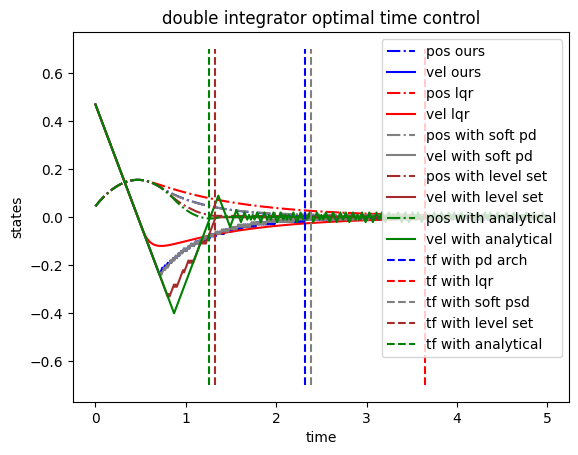

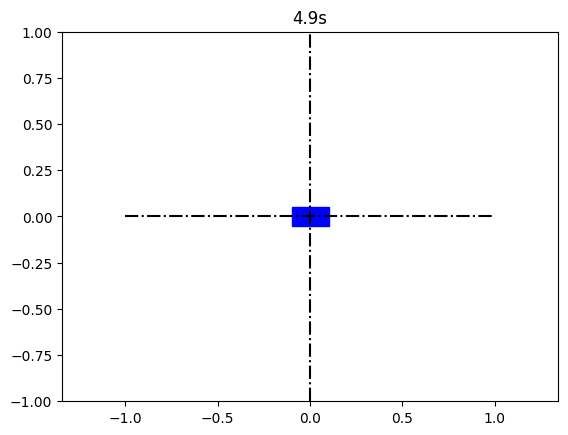

In [13]:
optimal_t_psd_list = []
optimal_t_soft_psd_list = [] 
optimal_t_lqr_list = []
optimal_t_level_set_list = []
optimal_t_analytical_list = []

x0 = np.random.uniform(low=-1,high=1, size=(2,))
ts, xs_psd, xs_soft_psd, xs_lqr, xs_level_set, xs_analytical, optimal_t_psd, optimal_t_soft_psd, optimal_t_lqr, optimal_t_level_set, optimal_t_analytical = test_learned_policy(x0)
optimal_t_psd_list.append(optimal_t_psd)
optimal_t_soft_psd_list.append(optimal_t_soft_psd)
optimal_t_lqr_list.append(optimal_t_lqr)
optimal_t_level_set_list.append(optimal_t_level_set)
optimal_t_analytical_list.append(optimal_t_analytical)

fig, anim = visualize_traj(ts, xs_psd, xs_soft_psd, xs_lqr, xs_level_set, xs_analytical, optimal_t_psd, optimal_t_soft_psd, optimal_t_lqr, optimal_t_level_set, optimal_t_analytical)
for i in range(1, 10):
    x0 = np.random.uniform(low=-1,high=1, size=(2,))
    ts, xs_psd, xs_soft_psd, xs_lqr, xs_level_set, xs_analytical, optimal_t_psd, optimal_t_soft_psd, optimal_t_lqr, optimal_t_level_set, optimal_t_analytical = test_learned_policy(x0)
    optimal_t_psd_list.append(optimal_t_psd)
    optimal_t_soft_psd_list.append(optimal_t_psd)
    optimal_t_lqr_list.append(optimal_t_lqr)
    optimal_t_level_set_list.append(optimal_t_level_set)
    optimal_t_analytical_list.append(optimal_t_analytical)

optimal_t_psd_list = np.array(optimal_t_psd_list)
optimal_t_soft_psd_list = np.array(optimal_t_soft_psd_list)
optimal_t_lqr_list = np.array(optimal_t_lqr_list)
optimal_t_level_set_list = np.array(optimal_t_level_set_list)
optimal_t_analytical_list = np.array(optimal_t_analytical_list)

In [14]:
print("mean psd: ", np.mean(optimal_t_psd_list))
print("mean soft psd: ", np.mean(optimal_t_soft_psd_list))
print("mean lqr: ", np.mean(optimal_t_lqr_list))
print("mean level set", np.mean(optimal_t_level_set_list))
print("mean analytical set", np.mean(optimal_t_analytical_list))

print("std psd: ", np.std(optimal_t_psd_list))
print("std soft psd: ", np.std(optimal_t_soft_psd_list))
print("std lqr: ", np.std(optimal_t_lqr_list))
print("std level set", np.std(optimal_t_level_set_list))
print("std analytical set", np.std(optimal_t_analytical_list))

mean psd:  2.964
mean soft psd:  2.97
mean lqr:  4.508000000000001
mean level set 1.8780000000000001
mean analytical set 1.8259999999999998
std psd:  0.5860409542003017
std soft psd:  0.5796895720987225
std lqr:  0.49773085096264624
std level set 0.5747834374788473
std analytical set 0.5929957841334119


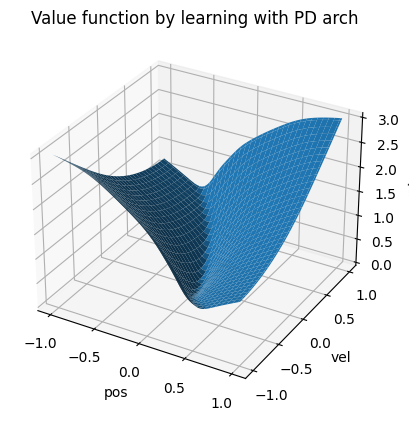

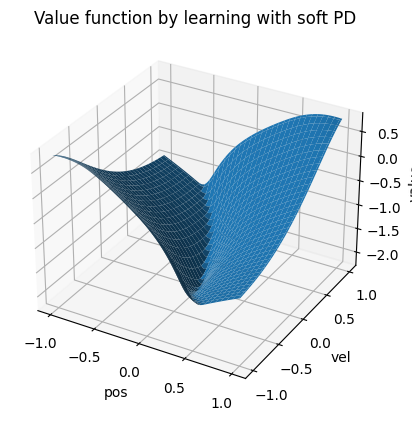

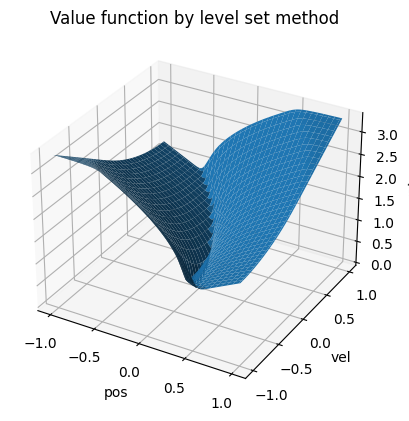

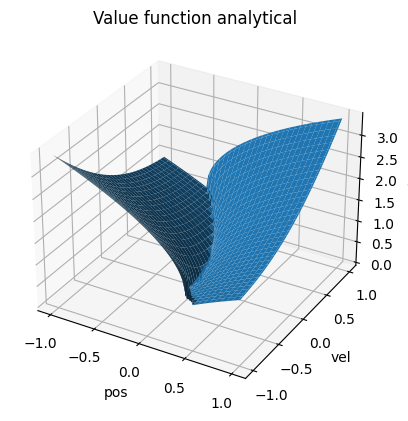

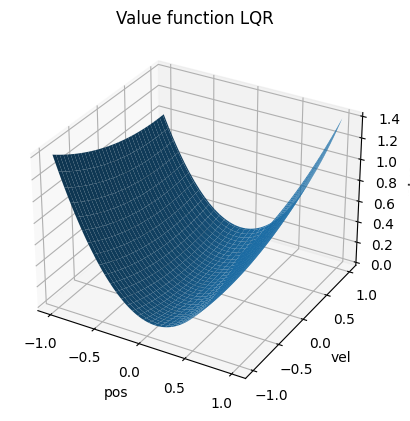

In [15]:
def visualize_learned_value_landscope(model, model_params, model_states, x_direction, y_direction, 
                        x_range=np.linspace(-1, 1, 101), y_range=np.linspace(-1, 1, 101), title="Learned value function"):
    """
    This function help to draw value function landscope for learn function,
    
    x_direction and y_direction should be perpenticular to each other, suppose a_i \in x_range, b_i \in y_range, then x_i = a_i * x_direction + b_i * y_direction.
    This is prepare for visualize state dimension higher than 2.

    Args:
        model: nn network object
        model_params: params for learned nn networks
        model_states: params for neural network states such as bn statistics
        x_direction: x axis direction
        y_direction: y axis direction
        x_range: the ranges for x direction
        y_range: the range for y direction
    """
    

    quick_apply = jax.jit(model.apply, static_argnames=["train"])
    X, Y = np.meshgrid(x_range, y_range)
    v_learned = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(Y.shape[1]):
            x = X[i,j] * x_direction
            x += Y[i,j] * y_direction
            v_learned[i,j] = quick_apply({"params":model_params, **model_states}, x)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, v_learned)
    ax.set_xlabel(f"pos")
    ax.set_ylabel(f"vel")
    ax.set_zlabel('value')
    plt.title(title)

def visualize_level_set_value_landscope():
    Pos, Vel = np.meshgrid(pos_span, vel_span)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Pos, Vel, value_function_by_level_set_method)
    ax.set_xlabel(f"pos")
    ax.set_ylabel(f"vel")
    ax.set_zlabel('value')
    plt.title("Value function by level set method")

def visualize_analytical_value_landscope():
    Pos, Vel = np.meshgrid(pos_span, vel_span)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Pos, Vel, value_function_by_analytical)
    ax.set_xlabel(f"pos")
    ax.set_ylabel(f"vel")
    ax.set_zlabel('value')
    plt.title("Value function analytical")

def visualize_lqr_value_landscope():
    Pos, Vel = np.meshgrid(pos_span, vel_span)
    v_lqr = np.zeros_like(Pos)
    for i in range(Pos.shape[0]):
        for j in range(Vel.shape[1]):
            x = np.array([Pos[i,j], Vel[i,j]])
            v_lqr[i, j] = x.T @ P @ x
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Pos, Vel, v_lqr)
    ax.set_xlabel(f"pos")
    ax.set_ylabel(f"vel")
    ax.set_zlabel('value')
    plt.title("Value function LQR")

x_direction = np.array([1,0])
y_direction = np.array([0,1])
visualize_learned_value_landscope(psd_value_function_approximator, psd_model_params, psd_model_states, x_direction=x_direction, y_direction=y_direction, title="Value function by learning with PD arch")
visualize_learned_value_landscope(soft_psd_value_function_approximator, soft_psd_model_params, soft_psd_model_states, x_direction=x_direction, y_direction=y_direction, title="Value function by learning with soft PD")
visualize_level_set_value_landscope()
visualize_analytical_value_landscope()
visualize_lqr_value_landscope()